# Plant Pathology
*Identify the category of foliar diseases in apple trees.*

Folder structuur voor een snel en makkelijk overzicht:
```bash
.
├───datasets
│   └───train.csv
├───images
│   ├───resized_train_images
│   └───train_images
├───foliar_diseases.ipynb
└───image_resizer.ipynb
```


## 0. Modules importeren

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
#importeer Tensorflow namespaces
import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from keras.optimizers import SGD
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf

## 1. Data inlezen.

### We maken een lijst van alle fotos in onze dataset.
\> lijst met lables  
\> lijst met fotos

In [2]:
directory = "images/resized_train_images/"
labels = pd.read_csv("datasets/train.csv")
label = labels["labels"].tolist()
images = labels["image"].tolist()
print(label[0], images[0])
img = io.imread(directory + images[0])/255
width = img.shape[0]
height = img.shape[1]

healthy 800113bb65efe69e.jpg


### LabelEncoder gebruiken om labels naar integers te converteren.

In [3]:
le = preprocessing.LabelEncoder()
le.fit(np.array(label).reshape(-1,))
y_encoded = le.transform(np.array(label).reshape(-1,))
print(y_encoded)

[ 3 11  9 ...  6 10  3]


### Fotos inlezen.

In [4]:
X = np.zeros((len(y_encoded),width,height,3)).astype(np.float32)

for i,img in enumerate(images):
    image = io.imread(directory + img)/255
    resized_image = image.astype(np.float32)
    X[i]=resized_image

### Train -en testsplits maken.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=1234)

print(X_train.shape)
print(y_train.shape)

(12483, 175, 175, 3)
(12483,)


### De uitkomst one-hot-encoderen.

In [6]:
y_train_onehot = to_categorical(y_train)

## 2. Basic CNN model

### Model builden, compileren en trainen:

We gebruiken een 'sequential model':

\> *Convolutional*:
 - 32 Feature maps + ReLU activation function  
 - MAX pooling
 - Batch Normalization

\> *Neural Network*:
 - Flatten (2D foto omzetten in een array)  
 - ReLU activation function  
 - Softmax activation function (12 outputs -> 11 plantenziekten + gezonde plant)

In [7]:
# Architecture

input_shape=(width,height,3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
    
model.add(Flatten()) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(12, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Train 
early_stopping =  EarlyStopping(patience=10)

fit1 = model.fit(X_train, y_train_onehot,batch_size=32, epochs=100,
                    validation_split=0.2,  callbacks=[early_stopping], verbose=1)

Epoch 1/100
313/313 [==============================] - 16s 36ms/step - loss: 4.4762 - accuracy: 0.2866 - val_loss: 1.9196 - val_accuracy: 0.2835
Epoch 2/100
313/313 [==============================] - 10s 31ms/step - loss: 1.4654 - accuracy: 0.4579 - val_loss: 1.8350 - val_accuracy: 0.3568
Epoch 3/100
313/313 [==============================] - 10s 31ms/step - loss: 1.1413 - accuracy: 0.6138 - val_loss: 2.5816 - val_accuracy: 0.2179
Epoch 4/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6933 - accuracy: 0.7702 - val_loss: 2.3735 - val_accuracy: 0.3560
Epoch 5/100
313/313 [==============================] - 10s 31ms/step - loss: 0.4628 - accuracy: 0.8620 - val_loss: 3.3481 - val_accuracy: 0.3356
Epoch 6/100
313/313 [==============================] - 10s 31ms/step - loss: 0.4273 - accuracy: 0.8619 - val_loss: 3.2409 - val_accuracy: 0.3024
Epoch 7/100
313/313 [==============================] - 10s 31ms/step - loss: 0.3291 - accuracy: 0.9004 - val_loss: 3.3953 - val_ac

### Plotten

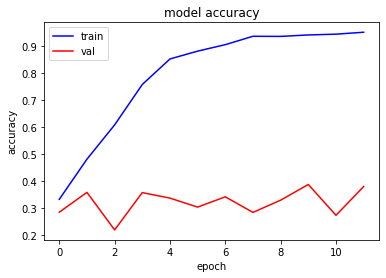

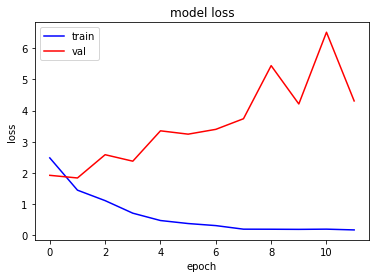

In [8]:
# Accuray 
plt.plot(fit1.history['accuracy'],'b', fit1.history['val_accuracy'],'r')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Loss 
plt.plot(fit1.history['loss'],'b', fit1.history['val_loss'],'r')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Uiteindelijk komen we op een accuracy/accuraatheid van 39,61%. **TO EDIT**

## 3. Data augmentatie

### Train/Validatie split

In [9]:
# splitting
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# one-hot encoding
y_train2_onehot = to_categorical(y_train2)
y_val_onehot = to_categorical(y_val)

### Model builden en compileren.

In [10]:
# Model
input_shape=(width,height,3)

def get_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape))) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten()) 
    model.add(Dense(50, activation='relu')) 
    model.add(Dense(12, activation='softmax'))
    return(model)

model = get_model() 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### ImageDataGenerator initiëren.

In [11]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator()
 

### Model trainen.
Aan de hand van 100 Epochs

In [12]:
early_stopping =  EarlyStopping(patience=5)
fit2_aug = model.fit_generator(aug.flow(X_train2, y_train2_onehot,batch_size=32), epochs=100,
                    steps_per_epoch=len(X_train2) // 32, callbacks=[early_stopping], verbose=1,validation_data = (X_val,y_val_onehot))


Epoch 1/100
312/312 [==============================] - 10s 31ms/step - loss: 3.8923 - accuracy: 0.2713 - val_loss: 2.0009 - val_accuracy: 0.2163
Epoch 2/100
312/312 [==============================] - 10s 30ms/step - loss: 1.5069 - accuracy: 0.3958 - val_loss: 1.8729 - val_accuracy: 0.2395
Epoch 3/100
312/312 [==============================] - 10s 31ms/step - loss: 1.2600 - accuracy: 0.5178 - val_loss: 2.1939 - val_accuracy: 0.3688
Epoch 4/100
312/312 [==============================] - 10s 31ms/step - loss: 0.9828 - accuracy: 0.6422 - val_loss: 3.4442 - val_accuracy: 0.1534
Epoch 5/100
312/312 [==============================] - 10s 31ms/step - loss: 0.7407 - accuracy: 0.7407 - val_loss: 3.7583 - val_accuracy: 0.3352
Epoch 6/100
312/312 [==============================] - 10s 31ms/step - loss: 0.5596 - accuracy: 0.8053 - val_loss: 2.7999 - val_accuracy: 0.3300
Epoch 7/100
312/312 [==============================] - 10s 31ms/step - loss: 0.5672 - accuracy: 0.8185 - val_loss: 4.6169 - val_ac

### Plot vergelijken met plot in stap 2.

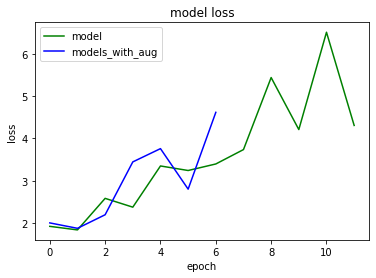

In [13]:
plt.plot( fit1.history['val_loss'],'g', fit2_aug.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model', 'models_with_aug'], loc='upper left')
plt.show()

**TODO: CONCLUSION**

## 4. Transfer learning via VGG19

### VGG19 Model initialiseren

In [14]:
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(width,height,3))
type(modelVGG19)

tensorflow.python.keras.engine.functional.Functional

### VGG19 model omzetten naar sequentieel model.

In [15]:
# Store as a sequential model.

model = Sequential()

for layer in modelVGG19.layers[:]:
    model.add(layer)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 43, 43, 256)      

### Layers in het model vastzetten.

In [16]:
for layer in model.layers:
    layer.trainable = False

### Top layers toevoegen aan het model

 - Flatten  
 - ReLU activation function  
 - Softmax activation function (12 outputs -> 11 plantenziekten + gezonde plant)

In [22]:
model.add(Flatten()) 
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(12, activation='softmax'))

### Model compileren en trainen

In [23]:
#Compile
model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['accuracy'])
model.summary()

# Train
batch_size = 16
early_stopping =  EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train_onehot,batch_size=batch_size, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 43, 43, 256)      

### Vergelijken met vorige modellen aan de hand van de plots
(Zie plots uit stap 2 en 3)

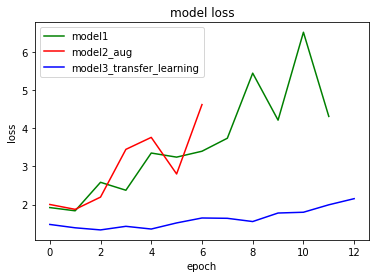

In [19]:
plt.plot( fit1.history['val_loss'],'g', fit2_aug.history['val_loss'],'r', history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model1', 'model2_aug', 'model3_transfer_learning'], loc='upper left')
plt.show()

**TODO: CONCLUSION**

## 5. Uitvoeren op testset

In [20]:
test_predict = model.predict_classes(X_test)
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.34      0.42      0.38       530
           1       0.49      0.51      0.50      1075
           2       0.00      0.00      0.00        48
           3       0.56      0.80      0.66      1563
           4       0.66      0.69      0.68       391
           5       0.00      0.00      0.00        31
           6       0.72      0.65      0.69       622
           7       0.00      0.00      0.00        33
           8       0.00      0.00      0.00        28
           9       0.64      0.48      0.55      1535
          10       0.00      0.00      0.00       215
          11       0.00      0.00      0.00        78

    accuracy                           0.56      6149
   macro avg       0.28      0.30      0.29      6149
weighted avg       0.53      0.56      0.54      6149



In [21]:
model.save("bestModel.h5")